In [1]:
# imports
import numpy as np
from scipy.integrate import ode
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap

import gzip
import pickle



In [2]:
# # Let's do it totally realistically:
# q = -1.602e-19
# m = 9.1e-31
# B0 = 30e-6

R2D = 180.0/np.pi
D2R = np.pi/180.0
# R_E = 6371.
# import numpy as np
# from numpy import arctan2, sqrt
# # import numexpr as ne

def spherical_to_cartesian(r_in):
    x = r_in[0]*np.cos(D2R*r_in[1])*np.cos(D2R*r_in[2])
    y = r_in[0]*np.cos(D2R*r_in[1])*np.sin(D2R*r_in[2])
    z = r_in[0]*np.sin(D2R*r_in[1])
    #print x, y, z
    return np.array([x, y, z]).T

def cartesian_to_spherical(x_in):
    ''' cartesian to spherical (degrees)'''
    rads = np.linalg.norm(x_in,axis=0)
    lons = R2D*np.arctan2(x_in[1], x_in[0]);
    lats = R2D*np.arcsin(x_in[2]/rads)
    return np.array([rads, lats, lons]).T

def bfield(x_in):
    Bo = (3.12e-5)
    D2R = np.pi/180.
    R_E = 6371e3;

    R = x_in[0]
    theta = (90. - x_in[1])*D2R
    phi   = x_in[2]*D2R
    
    Bor3  = Bo*pow(R, -3.0)
    
    Brad = -2.0*Bor3*np.cos(theta);
    Btheta = -1.0*Bor3*np.sin(theta);
    Bphi = 0.0;    # Dipole model has no variation in longitude (here for completeness)

    B_out = np.zeros(3)
    B_out[0] = Brad;        # Up
    B_out[1] = Btheta;      # South
    B_out[2] = Bphi;        # East

    return B_out
def transform_data_sph2car(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M, d_in)

    return d_out

def transform_data_car2sph(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M.T, d_in)

    return d_out

In [3]:
def newton(t, Y, q, m, B):  
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    This version takes B as a vector.
    """
    x, y, z = Y[0], Y[1], Y[2]
    u, v, w = Y[3], Y[4], Y[5]
    
    dv = np.cross(Y[3:6], B)*q / m
    alpha = q / m * np.linalg.norm(B)
    
    return np.array([u, v, w, dv[0], dv[1], dv[2]])

In [4]:
# Load coastlines (for plotting)
with gzip.open('mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

['lat', 'lon']


In [29]:
R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.

# Let's do it totally realistically:
q = -1.602e-19
m = (9.1e-31)*1   # Tripling the mass to make the radius more-visible
Bo = (3.12e-5)
c = 2.99e8
E_EL = 5.105396765648739e5
ke = 0.002        # electron energy in ev
alpha = 5 #30        # equatorial pitch angle
L = 4  

t1 = 15e-4 # stop time
dt = 5e-8 # timestep 

vtot = c*np.sqrt(1 - pow( (E_EL/(E_EL+ke)),2))

x0_sph = np.array([L, 0, 0])

x0 = spherical_to_cartesian(x0_sph)
v0 = np.array([np.sin(alpha*D2R), 0, np.cos(alpha*D2R)])*vtot
initial_conditions = np.concatenate((x0, v0))

Bsph = bfield(x0_sph)
B = transform_data_sph2car(x0_sph[1], x0_sph[2], Bsph)

# Start the integrator
r = ode(newton).set_integrator('dopri5')
r.set_initial_value(initial_conditions, 0).set_f_params(q, m, B)

positions = []
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    positions.append(r.y[:3]) # keeping only position, not velocity
    xsph = cartesian_to_spherical(r.y[:3])
    Bsph = bfield(xsph)
    Bcar = transform_data_sph2car(xsph[1], xsph[2], Bsph)
    r.set_f_params(q, m, Bcar)

positions = np.array(positions)

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


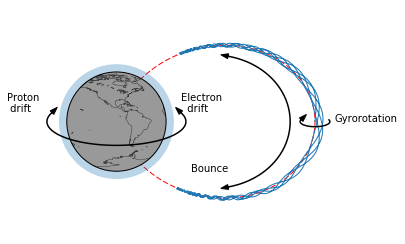

In [161]:


# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'font.family': 'Sans Serif',
          'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,1)
[i.set_linewidth(0) for i in ax.spines.itervalues()]


ax.set_aspect('equal')
ax.set_xlim([-1.5,L + 0.5])
ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
# ax.set_yticks([ -1, 0, 1])
ax.set_yticks([])
ax.set_xticks([])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6, linewidth=0.5)


# Plot trajectory
ax.plot(np.linalg.norm(positions[:,0:2],axis=1), positions[:,2], linewidth=1, zorder=80)


# Plot latitude lines:

# for la in np.arange(-80, 81, 10):
#     rr = np.array([1,10])
#     plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    

# Plot the fieldlines
lam = np.linspace(-80,80,181)
L_r = L*pow(np.cos(lam*D2R),2)
Lx  = L_r*np.cos(lam*D2R)
Ly  = L_r*np.sin(lam*D2R)
ax.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed', zorder=10)  # Field line


# Annotations:

th = np.linspace(-200*D2R,20*D2R, 100)
tr = 1.4

ph = 20*D2R
c = np.cos(ph)
s = np.sin(ph)
R = np.array([[1.,0,0],[0,c,-s],[0,s,c]])

m = np.dot(R, np.array([tr*np.cos(th),tr*np.sin(th),np.zeros_like(th)]))

ax.plot(m[0,:], m[2,:], color='k', zorder=120)
ax.arrow(m[0,-1], m[2,-1], (m[0,-1] - m[0,-2]),(m[2,-1] - m[2,-2]), head_width=0.1, facecolor='k')
ax.arrow(m[0,0], m[2,0], (m[0,0] - m[0,1]),(m[2,0] - m[2,1]), head_width=0.1, facecolor='k')

ax.text(1.3,0.2,'Electron\n  drift')
ax.text(-2.2,0.2,'Proton\n drift')


th = np.linspace(-200*D2R,20*D2R, 100)
tr = 0.3
m = np.dot(R, np.array([L + tr*np.cos(th),tr*np.sin(th),np.zeros_like(th)]))
ax.plot(m[0,:], m[2,:], color='k', zorder=120)
# ax.arrow(m[0,-1], m[2,-1], (m[0,-1] - m[0,-2]),(m[2,-1] - m[2,-2]), head_width=0.1, facecolor='k')
ax.arrow(m[0,0], m[2,0], (m[0,0] - m[0,1]),(m[2,0] - m[2,1]), head_width=0.1, facecolor='k')
ax.text(L+0.4,0,'Gyrorotation')


lam = np.linspace(-30,30,181)
L_r = (L-0.5)*pow(np.cos(lam*D2R),2)
Lx  = L_r*np.cos(lam*D2R)
Ly  = L_r*np.sin(lam*D2R)
ax.plot(Lx,Ly,color='k')
ax.arrow(Lx[0], Ly[0], (Lx[0]-Lx[1]), (Ly[0]-Ly[1]), head_width=0.1, facecolor='k')
ax.arrow(Lx[-1], Ly[-1], (Lx[-1]-Lx[-2]), (Ly[-1]-Ly[-2]), head_width=0.1, facecolor='k')

ax.text(1.5,-1,'Bounce')
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.85)
fig.savefig('particle_motions.pdf', bbox_inches=0)




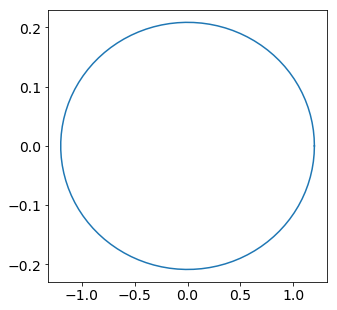

In [67]:

th = np.linspace(0,2.*np.pi, 100)
tr = 1.2
tx = np.cos(th)*tr
ty = np.sin(th)*tr
tz = np.zeros_like(th)

p = 10*D2R
c = np.cos(p)
s = np.sin(p)
R = np.array([[1,0,0],[0,c,-s],[0,s,c]])

m = np.dot(R, np.array([tx,ty,tz]))

fig, ax = plt.subplots(1,1)
ax.plot(m[0,:], m[2,:])

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in less


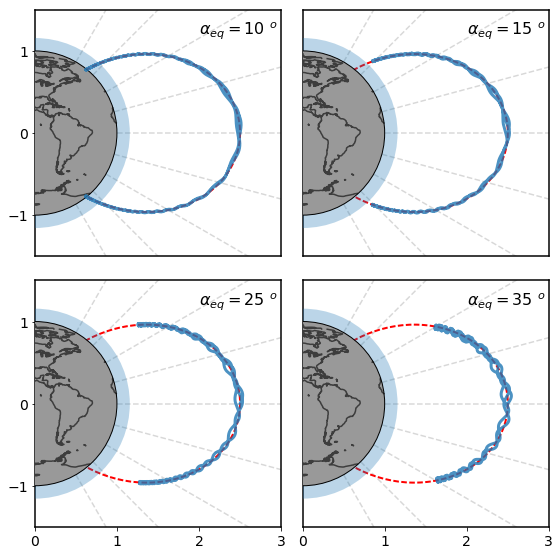

In [25]:
# Loss-cone angle:
Bo_eq = np.linalg.norm(bfield([L, 0,0]))
lam_iono = np.arccos(np.sqrt((R_E + 1000.)/L/R_E))
B_iono = np.linalg.norm(Bo_eq*np.sqrt(1. + 3*pow(np.sin(lam_iono), 2))/pow(np.cos(lam_iono),6.))

alpha_lc = np.arcsin(np.sqrt(Bo_eq/B_iono))
print alpha_lc*R2D

14.3385374025


## This one for the thesis:

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in less


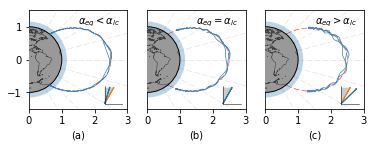

In [124]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes


# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 1.25
fig_size =  [fig_width+1,fig_height+1]
params = {'font.family': 'Sans Serif',
          'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------




R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.

# Let's do it totally realistically:
q = -1.602e-19
m = (9.1e-31)*1   # Tripling the mass to make the radius more-visible
Bo = (3.12e-5)
c = 2.99e8
E_EL = 5.105396765648739e5 # rest energy of electron, in ev
ke = 0.005        # electron energy in ev
alphas = [8, 14, 25]        # equatorial pitch angle
L = 2.5 

t1 = 3e-4 # stop time
dt = 5e-8 # timestep 

fig, axlist = plt.subplots(1,3)

axlist = axlist.flatten()

for aind, alpha in enumerate(alphas):
    
    # -------- Do the integration ----------
    vtot = c*np.sqrt(1 - pow( (E_EL/(E_EL+ke)),2))
    x0_sph = np.array([L, 0, 0])
    x0 = spherical_to_cartesian(x0_sph)
    v0 = np.array([np.sin(alpha*D2R), 0, np.cos(alpha*D2R)])*vtot
    initial_conditions = np.concatenate((x0, v0))
    Bsph = bfield(x0_sph)
    B = transform_data_sph2car(x0_sph[1], x0_sph[2], Bsph)
    
    # Start the integrator
    r = ode(newton).set_integrator('dopri5')
    r.set_initial_value(initial_conditions, 0).set_f_params(q, m, B)

    positions = []
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        positions.append(r.y[:3]) # keeping only position, not velocity
        xsph = cartesian_to_spherical(r.y[:3])
        Bsph = bfield(xsph)
        Bcar = transform_data_sph2car(xsph[1], xsph[2], Bsph)
        r.set_f_params(q, m, Bcar)

    positions = np.array(positions)
    
    # ----- Plot it --------
    ax = axlist[aind]
#     [i.set_linewidth(1.5) for i in ax.spines.itervalues()] # Set plot border thickness
    ax.plot(positions[:,0], positions[:,2], linewidth=0.8, zorder=100, alpha=0.8)
    ax.set_aspect('equal')
    ax.set_xlim([0,L + 0.5])
    ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
    ax.set_yticks([ -1, 0, 1])
    # Draw the earth
    # Plot the earth
    earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
    iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)

    ax.add_patch(earth)                    # The earth (round)
    ax.add_patch(iono)
    coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
    coastr = np.linalg.norm(coastpoints, axis=0)
    coastmask = (coastr < 1) | (np.isnan(coastr))
    ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6, linewidth=0.5)



    # ax2=fig.add_axes([0,0.25,0.52,0.5])
    # m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
    # m.bluemarble(scale=.5) # scale=.1 for low resolution

    # Plot latitude lines:

    for la in np.arange(-60, 61, 15):
        rr = np.array([1,10])
        ax.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3, linewidth=0.5)

    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=0.5,linestyle='dashed', zorder=98)  # Field line
    
#     ax.text(1.3, 1.1, r'$\alpha_{eq}=$%d $^o$'%alpha)
    ops = ['<','=','>']
    ax.text(1.5, 1.1, r'$\alpha_{eq} %s \alpha_{lc}$'%ops[aind])
    
    
    
    ix = inset_axes(ax,width="20%", height="20%", loc=4)
    [i.set_linewidth(0) for i in ix.spines.itervalues()] # Set plot border thickness

    ix.fill_between([0, np.sin(alpha_lc)], [0,1],[1,1], facecolor='0.8', interpolate=True)

    ix.arrow(0, 0, np.sin(alpha_lc), np.cos(alpha_lc), color=plt.cm.Vega10(1), head_width=0.03)
    ix.arrow(0, 0, np.sin(alpha*D2R), np.cos(alpha*D2R), color=plt.cm.Vega10(0), head_width=0.03)


    ix.plot([0,0],[0,1.1],'k', linewidth=0.5)
    ix.plot([0,0.5],[0,0],'k', linewidth=0.5)
    ix.set_xticks([])
    ix.set_yticks([])
    

axlist[1].set_yticks([])
axlist[2].set_yticks([])
# axlist[3].set_yticks([])
axlist[0].set_xticks([0,1,2,3])
axlist[1].set_xticks([0,1,2,3])
axlist[2].set_xticks([0,1,2,3])
axlist[0].set_xlabel('(a)')
axlist[1].set_xlabel('(b)')
axlist[2].set_xlabel('(c)')
# fig.tight_layout()

fig.savefig('pitchangle_trapping_3up.pdf')

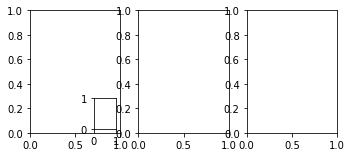

In [65]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig, ax = plt.subplots(1,3)

inset_axes = inset_axes(ax[0],width="25%", height="25%", loc=4)


14.3385374025


[]

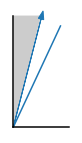

In [105]:

# Loss-cone angle:
Bo_eq = np.linalg.norm(bfield([L, 0,0]))
lam_iono = np.arccos(np.sqrt((R_E + 1000.)/L/R_E))
B_iono = np.linalg.norm(Bo_eq*np.sqrt(1. + 3*pow(np.sin(lam_iono), 2))/pow(np.cos(lam_iono),6.))

alpha_lc = np.arcsin(np.sqrt(Bo_eq/B_iono))
print alpha_lc*R2D


fig, ax = plt.subplots(1,1)
# ax.spines[u'right'].set_linewidth(0)
# ax.spines[u'top'].set_linewidth(0)
[i.set_linewidth(0) for i in ax.spines.itervalues()] # Set plot border thickness

# ax.plot([0, np.sin(alpha_lc)], [0, np.cos(alpha_lc)])
ax.arrow(0, 0, np.sin(alpha_lc), np.cos(alpha_lc), color=plt.cm.Vega10(0), head_width=0.05)
ax.plot([0, np.sin(alpha*D2R)], [0, np.cos(alpha*D2R)])

x = [0, np.sin(alpha_lc)]
y1 = [0,1]
y2 = [1,1]
ax.fill_between([0, np.sin(alpha_lc)], [0,1],[1,1], facecolor='0.8', interpolate=True)

ax.plot([0,0],[0,1],'k')
ax.plot([0,0.5],[0,0],'k')


ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])




In [42]:
from methods.find_crossings import gen_EA_array
# --------------- Latex Plot Beautification --------------------------
fig_width = 10 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

Lvec = np.arange(1.5, 5, 0.5)
Lmax = 4


fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
# ax.plot(positions[:,0], positions[:,2], linewidth=2)
ax.set_aspect('equal')
ax.set_xlim([-Lmax - 0.8,Lmax + 0.8])
ax.set_ylim(np.array([-1, 1])*(Lmax + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-90, 91, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    plt.plot(-rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)

    

# Plot the fieldlines
lam = np.linspace(-80,80,181)
for L in Lvec:
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot( Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line
    ax.plot(-Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line
    ax.text(L-0.2, 0, '%.1f'%L, size=14)
    
ax.set_xlabel('L (R$_E$)')
ax.set_ylabel('L (R$_E$)')
fig.tight_layout()
fig.savefig('dipole_field.png', dpi=300)

ImportError: No module named methods.find_crossings